# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc._settings.ScanpyConfig.n_jobs = 16

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 11s, sys: 9.26 s, total: 1min 21s
Wall time: 1min 21s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 

# USE_FIRST_N_CELLS = 1000000
# adata = adata[0:USE_FIRST_N_CELLS]
# adata.shape

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 2min 11s, sys: 44.3 s, total: 2min 55s
Wall time: 2min 55s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 1min 2s, sys: 21.9 s, total: 1min 24s
Wall time: 1min 24s


In [10]:
adata.shape

(1291337, 24002)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 8.22 s, sys: 2.12 s, total: 10.3 s
Wall time: 10.3 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 29.9 s, sys: 3.08 ms, total: 29.9 s
Wall time: 29.9 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 49.5 s, sys: 122 ms, total: 49.6 s
Wall time: 49.7 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 33.4 s, sys: 2.59 s, total: 36 s
Wall time: 36 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 2min 21s, sys: 3min 48s, total: 6min 9s
Wall time: 11min 7s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 48.1 s, sys: 5.55 s, total: 53.6 s
Wall time: 53.6 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 1106.956532239914


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 3h 9min 9s, sys: 10min 47s, total: 3h 19min 56s
Wall time: 3min 10s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, use_fast_tsne=True)

CPU times: user 6h 48min 16s, sys: 6min 8s, total: 6h 54min 24s
Wall time: 1h 49min 17s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 2h 32min 14s, sys: 2h 3min 51s, total: 4h 36min 5s
Wall time: 4min 17s


... storing 'kmeans' as categorical


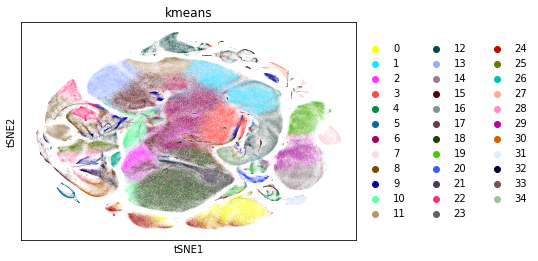

CPU times: user 6.3 s, sys: 432 ms, total: 6.73 s
Wall time: 7 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

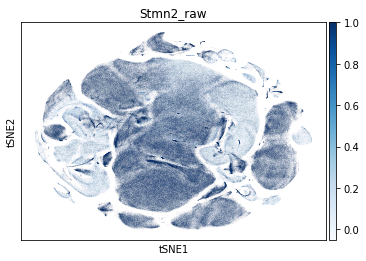

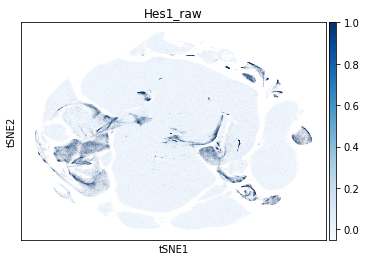

CPU times: user 6.87 s, sys: 317 ms, total: 7.18 s
Wall time: 6.69 s


In [22]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 28min 8s, sys: 35min 54s, total: 1h 4min 3s
Wall time: 2min 25s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 15h 43min 16s, sys: 2h 22min 56s, total: 18h 6min 13s
Wall time: 16min 9s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 17min 2s, sys: 6.26 s, total: 17min 8s
Wall time: 17min 6s


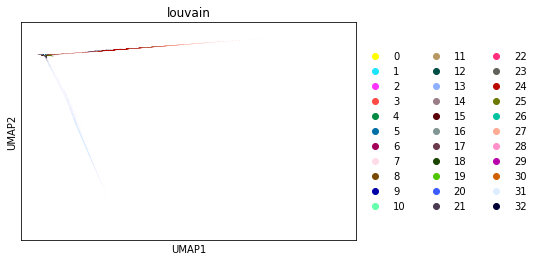

CPU times: user 5.99 s, sys: 218 ms, total: 6.21 s
Wall time: 5.97 s


In [26]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [27]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


CPU times: user 1h 4min 39s, sys: 2min 2s, total: 1h 6min 41s
Wall time: 1h 6min 29s


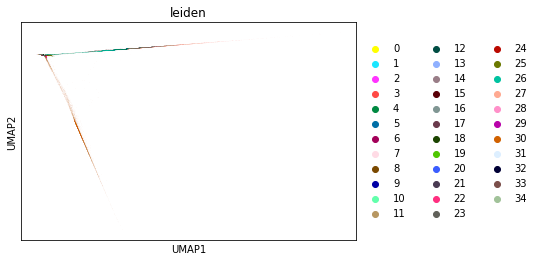

CPU times: user 5.92 s, sys: 191 ms, total: 6.11 s
Wall time: 5.87 s


In [28]:
%%time
sc.pl.umap(adata, color=["leiden"])

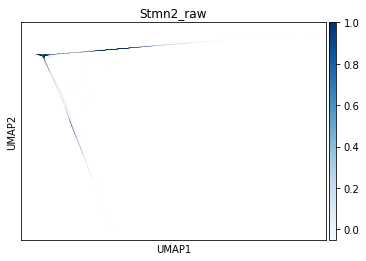

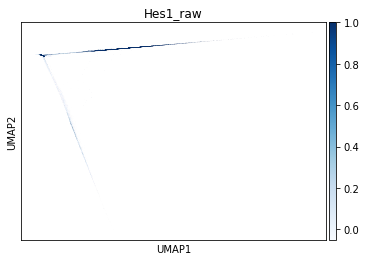

CPU times: user 6.8 s, sys: 237 ms, total: 7.03 s
Wall time: 6.54 s


In [29]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

In [30]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=50, groups='all', reference='rest', method='logreg')

CPU times: user 16h 47min 13s, sys: 1h 42min 44s, total: 18h 29min 58s
Wall time: 18min 46s


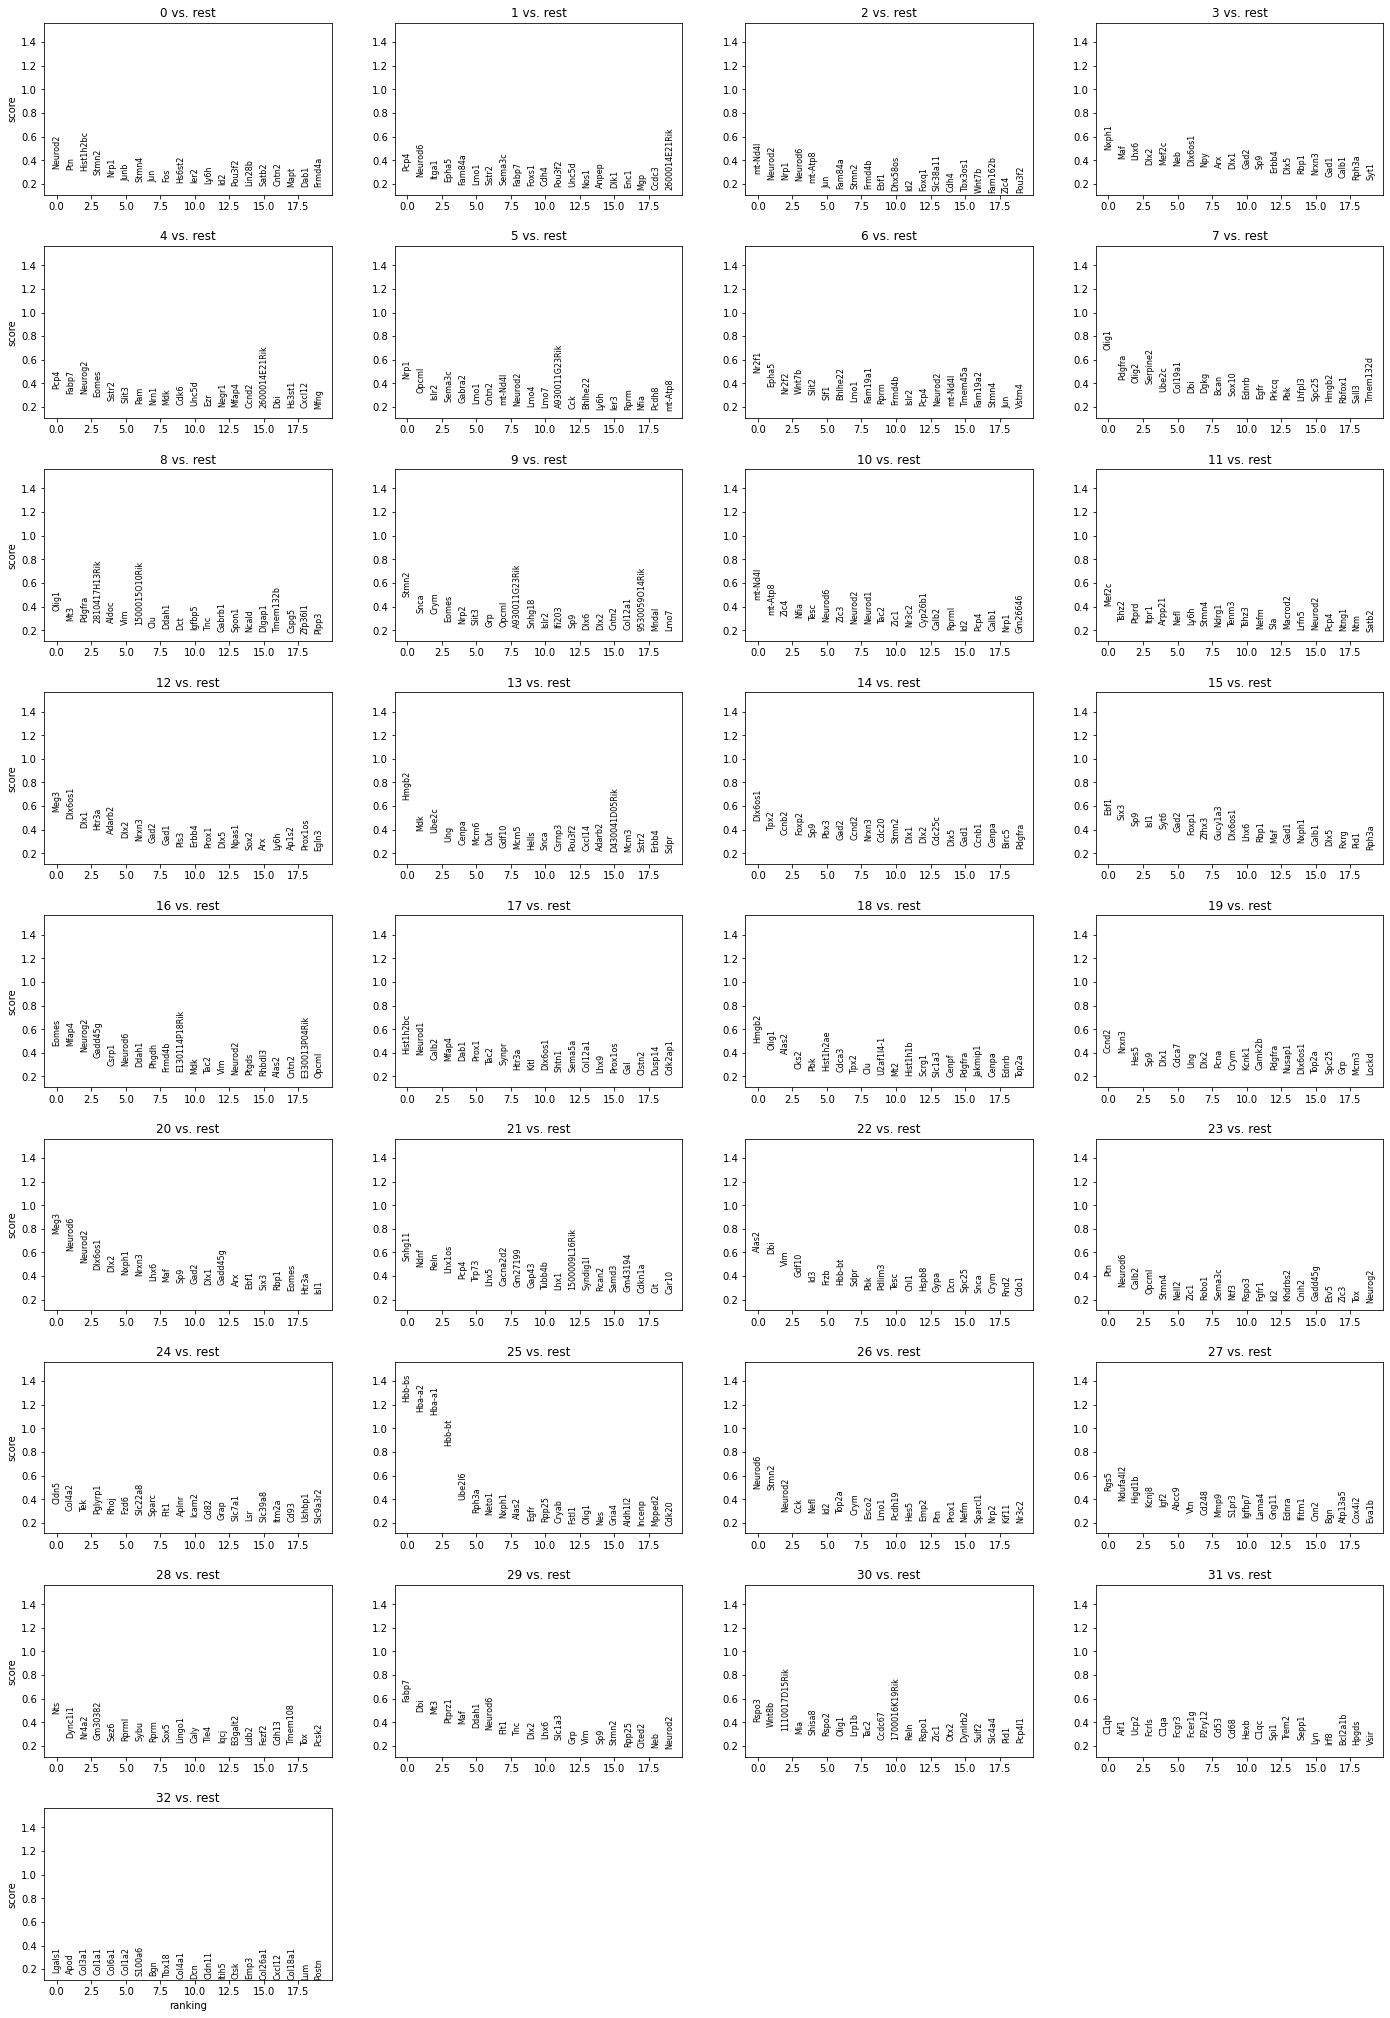

CPU times: user 5.33 s, sys: 2.37 s, total: 7.71 s
Wall time: 7.46 s


In [31]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [32]:
reanalysis_start = time.time()

In [33]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(120309, 4000)
CPU times: user 4.46 s, sys: 419 ms, total: 4.88 s
Wall time: 4.87 s


In [34]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 46min 33s, sys: 12min 50s, total: 59min 23s
Wall time: 1min 49s


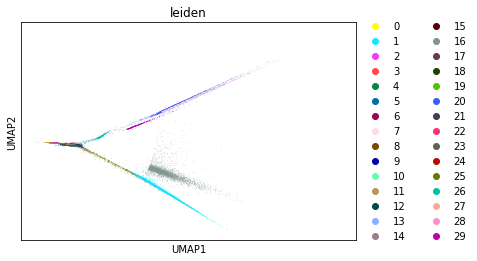

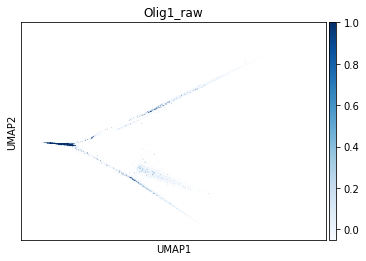

CPU times: user 1.77 s, sys: 261 ms, total: 2.04 s
Wall time: 1.54 s


In [35]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [36]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 115.8162431716919


In [37]:
print("Full time: %s" % (time.time() - start))

Full time: 15607.206044435501
